# Fantasy Premier League Data Exploration

This notebook helps you explore and analyze FPL data from the API and CDF.


In [1]:
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.fpl_client import FPLClient

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Fetch Data from FPL API


In [2]:
# Initialize FPL client
client = FPLClient()

# Get bootstrap data
print("Fetching bootstrap data...")
bootstrap = client.get_bootstrap_static()

print(f"Players: {len(bootstrap['elements'])}")
print(f"Teams: {len(bootstrap['teams'])}")
print(f"Gameweeks: {len(bootstrap['events'])}")


Fetching bootstrap data...
Players: 752
Teams: 20
Gameweeks: 38


## 2. Player Analysis


In [3]:
# Convert players to DataFrame
players_df = pd.DataFrame(bootstrap['elements'])

# Add position names
position_map = {1: 'GKP', 2: 'DEF', 3: 'MID', 4: 'FWD'}
players_df['position_name'] = players_df['element_type'].map(position_map)

# Add team names
teams_df = pd.DataFrame(bootstrap['teams'])
team_map = teams_df.set_index('id')['name'].to_dict()
players_df['team_name'] = players_df['team'].map(team_map)

# Convert price
players_df['price'] = players_df['now_cost'] / 10

players_df.head()


,can_transact,can_select,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,...,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,defensive_contribution_per_90,position_name,team_name,price
0,True,True,NaN,NaN,154561,0,0,4,-4,1,...,39,2,9,2,1.0,0.64,0.00,GKP,Arsenal,5.9
1,True,True,NaN,NaN,109745,0,0,-3,3,0,...,559,75,244,34,0.0,0.00,0.00,GKP,Arsenal,4.2
2,True,False,0.0,0.0,463748,0,0,0,0,0,...,524,62,323,47,0.0,0.00,0.00,GKP,Arsenal,4.0
3,True,True,NaN,NaN,551221,0,0,0,0,0,...,541,71,360,54,0.0,0.00,0.00,GKP,Arsenal,4.0
4,True,True,75.0,100.0,226597,0,0,6,-6,3,...,2,1,4,1,1.0,0.64,9.09,DEF,Arsenal,6.6


## 3. Top Players by Total Points


In [4]:
# Top 20 players
top_players = players_df.nlargest(20, 'total_points')[['web_name', 'team_name', 'position_name', 'total_points', 'price', 'selected_by_percent']]

print("Top 20 Players by Total Points:")
print(top_players.to_string(index=False))


Top 20 Players by Total Points:
  web_name      team_name position_name  total_points  price selected_by_percent
   Haaland       Man City           FWD           102   14.9                70.8
   Gabriel        Arsenal           DEF            81    6.6                43.7
   Semenyo    Bournemouth           MID            75    8.1                64.1
  J.Timber        Arsenal           DEF            67    6.1                25.6
      Rice        Arsenal           MID            65    6.9                20.7
     Guéhi Crystal Palace           DEF            64    5.1                34.6
 Calafiori        Arsenal           DEF            61    5.8                16.0
    Thiago      Brentford           FWD            60    6.3                10.9
   Caicedo        Chelsea           MID            60    6.1                23.3
     Muñoz Crystal Palace           DEF            60    5.7                16.2
    Mbeumo        Man Utd           MID            60    8.5                3

## 4. Value Analysis - Points per Million


In [5]:
# Calculate points per million
players_df['points_per_million'] = players_df['total_points'] / players_df['price']

# Filter players with at least 90 minutes played
active_players = players_df[players_df['minutes'] > 90].copy()

# Top value players by position
for position in ['GKP', 'DEF', 'MID', 'FWD']:
    pos_players = active_players[active_players['position_name'] == position]
    top_value = pos_players.nlargest(10, 'points_per_million')[['web_name', 'team_name', 'total_points', 'price', 'points_per_million']]
    
    print(f"\n{position} - Best Value:")
    print(top_value.to_string(index=False))



GKP - Best Value:
 web_name      team_name  total_points  price  points_per_million
    Roefs     Sunderland            56    4.7           11.914894
     Pope      Newcastle            52    5.2           10.000000
  Vicario          Spurs            47    5.0            9.400000
Henderson Crystal Palace            45    5.0            9.000000
     Raya        Arsenal            53    5.9            8.983051
 Petrović    Bournemouth            40    4.5            8.888889
 Dúbravka        Burnley            35    4.0            8.750000
 Martinez    Aston Villa            40    5.0            8.000000
  Sánchez        Chelsea            37    4.8            7.708333
 Pickford        Everton            42    5.5            7.636364

DEF - Best Value:
  web_name      team_name  total_points  price  points_per_million
     Guéhi Crystal Palace            64    5.1           12.549020
     Keane        Everton            56    4.5           12.444444
   Gabriel        Arsenal          

## 5. Your League - Null digge damer igjen på Meny


In [9]:
# Your league ID
LEAGUE_ID = "1097811"  # Null digge damer igjen på Meny

# Get league standings
print("Fetching league data...")
league_data = client.get_league_standings(LEAGUE_ID)

league_info = league_data['league']
standings = league_data['standings']['results']

print(f"\nLeague: {league_info['name']}")
print(f"Total managers: {len(standings)}")
print("\n" + "="*80)
print("LEAGUE STANDINGS")
print("="*80)


Fetching league data...

League: Null digge damer igjen på Meny
Total managers: 27

LEAGUE STANDINGS


In [10]:
# Create DataFrame of standings
standings_df = pd.DataFrame(standings)

# Display key columns
display_cols = ['rank', 'player_name', 'entry_name', 'total', 'event_total']
standings_display = standings_df[display_cols].copy()
standings_display.columns = ['Rank', 'Manager', 'Team Name', 'Total Points', 'This GW']

print(standings_display.to_string(index=False))
print("\n" + "="*80)


 Rank                          Manager            Team Name  Total Points  This GW
    1                    edvard ekberg      cashmoneyflowyo           684       56
    2         Andreas Horten Jespersen           ballers fc           668       33
    3                 Andreas Røgeberg              Røge BK           661       51
    4                   Martin Tørhaug     Ekitikka MoSalah           660       38
    5                   Stian Røgeberg              Røge FC           659       39
    6                     Håkon Kornmo       Rice Rice baby           655       30
    7                   Arnstein Nisja       Casting Crouch           655       44
    8                   Even H. Larsen   Mekka’s Gatelag IL           652       62
    9                       Hakon Ness           salah goat           647       41
   10                      Mathias Moe          real gooner           645       54
   11                  Julian Dahlskås    Yoro Wizard Harry           643       44
   1

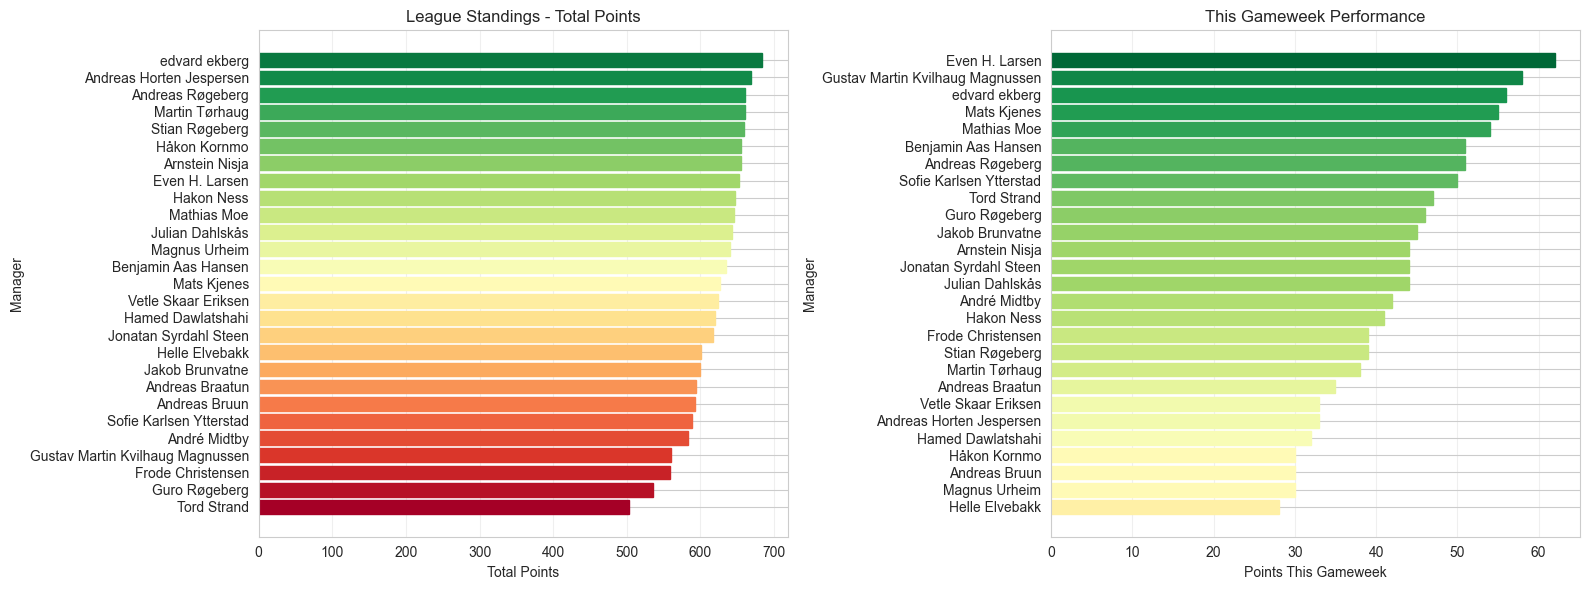

In [11]:
# Visualize league standings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Total points comparison
standings_sorted = standings_df.sort_values('total', ascending=True)
bars1 = ax1.barh(standings_sorted['player_name'], standings_sorted['total'])

# Color the bars by rank
colors_rank = plt.cm.RdYlGn_r(standings_sorted['rank'] / standings_sorted['rank'].max())
for bar, color in zip(bars1, colors_rank):
    bar.set_color(color)

ax1.set_xlabel('Total Points')
ax1.set_ylabel('Manager')
ax1.set_title('League Standings - Total Points')
ax1.grid(axis='x', alpha=0.3)

# This gameweek comparison
standings_sorted_gw = standings_df.sort_values('event_total', ascending=True)
bars2 = ax2.barh(standings_sorted_gw['player_name'], standings_sorted_gw['event_total'])

# Color by this gameweek performance
colors_gw = plt.cm.RdYlGn(standings_sorted_gw['event_total'] / standings_sorted_gw['event_total'].max())
for bar, color in zip(bars2, colors_gw):
    bar.set_color(color)

ax2.set_xlabel('Points This Gameweek')
ax2.set_ylabel('Manager')
ax2.set_title('This Gameweek Performance')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Manager History - Performance Over Time


In [12]:
# Get current gameweek
current_gw = client.get_current_gameweek()
print(f"Current gameweek: {current_gw}")

# Fetch history for top 5 managers (to avoid too many API calls)
top_5_managers = standings_df.nlargest(5, 'total')

manager_histories = []

for _, manager in top_5_managers.iterrows():
    entry_id = manager['entry']
    manager_name = manager['player_name']
    
    print(f"Fetching history for {manager_name}...")
    
    try:
        history = client.get_entry_history(entry_id)
        
        for gw in history.get('current', []):
            manager_histories.append({
                'manager': manager_name,
                'gameweek': gw['event'],
                'points': gw['points'],
                'total_points': gw['total_points'],
                'rank': gw['overall_rank'],
                'gw_rank': gw['rank'],
                'transfers': gw['event_transfers'],
                'transfer_cost': gw['event_transfers_cost'],
                'value': gw['value'] / 10  # Convert to millions
            })
    except Exception as e:
        print(f"  Error: {e}")
        continue

history_df = pd.DataFrame(manager_histories)
print(f"\nLoaded history for {history_df['manager'].nunique()} managers")


Current gameweek: 11
Fetching history for edvard ekberg...
Fetching history for Andreas Horten Jespersen...
Fetching history for Andreas Røgeberg...
Fetching history for Martin Tørhaug...
Fetching history for Stian Røgeberg...

Loaded history for 5 managers


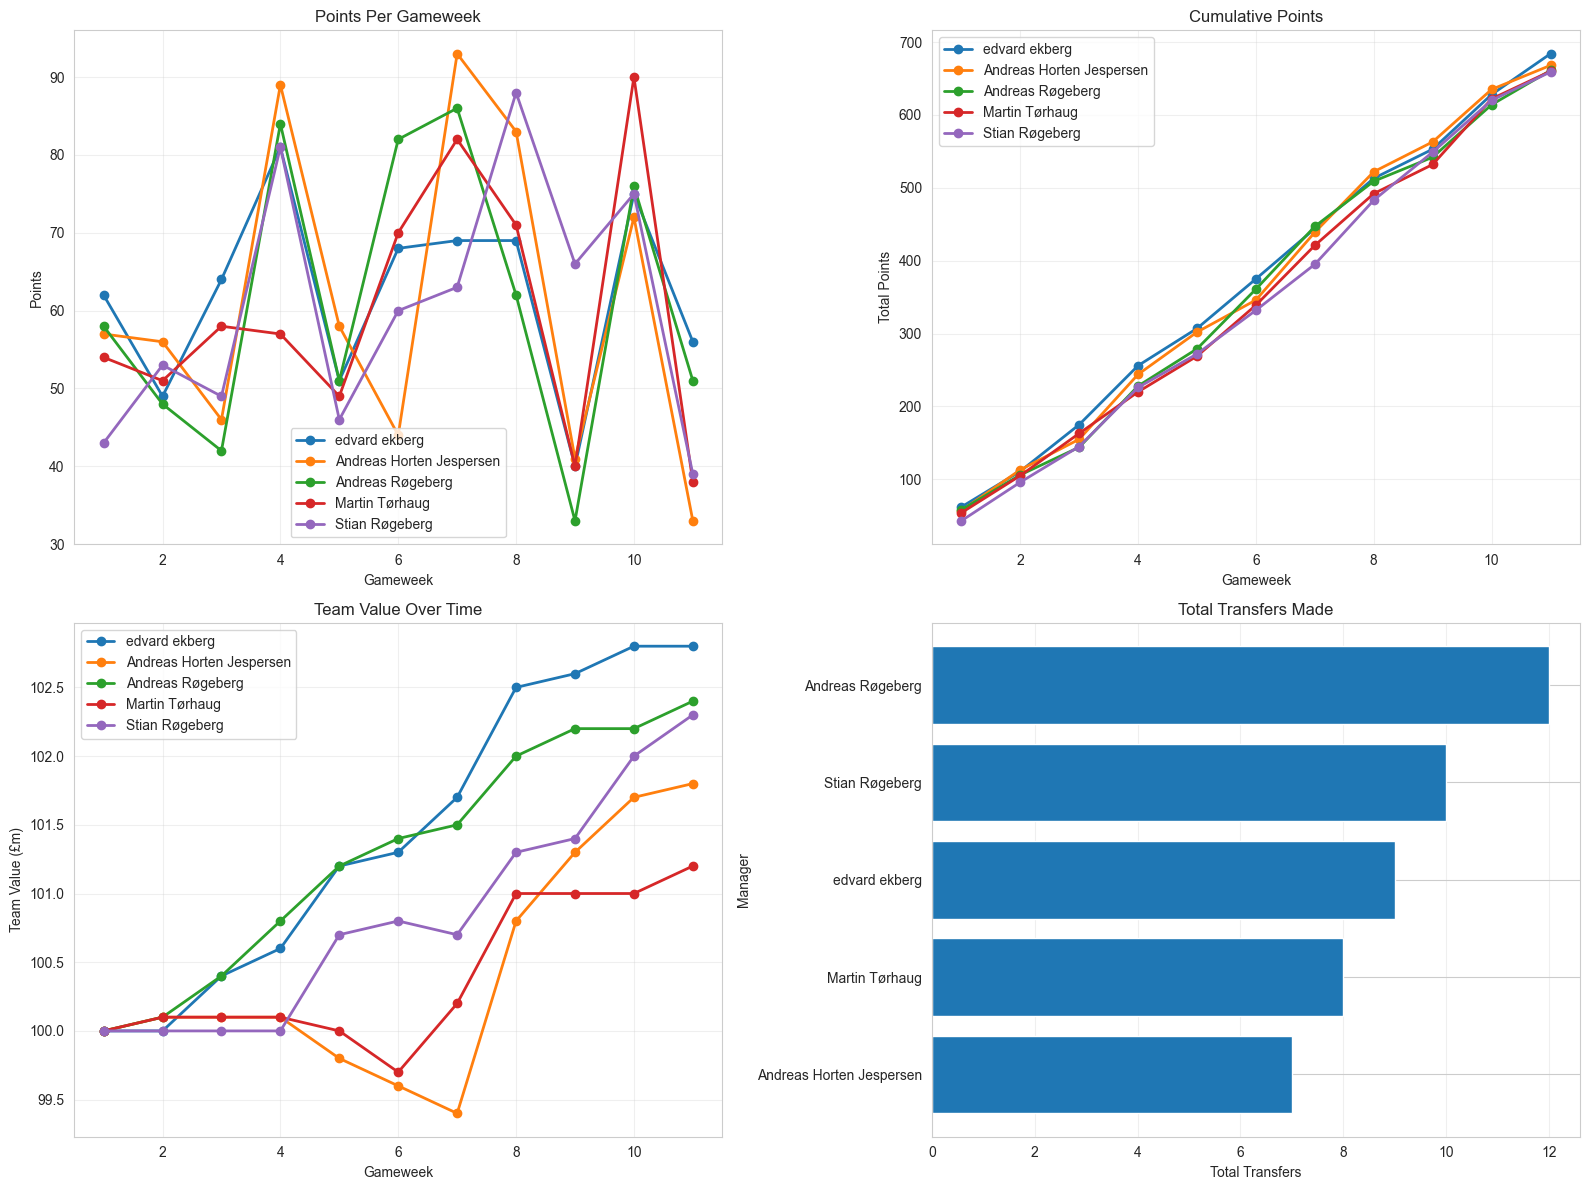

In [13]:
# Plot gameweek points over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Points per gameweek
ax1 = axes[0, 0]
for manager in history_df['manager'].unique():
    manager_data = history_df[history_df['manager'] == manager]
    ax1.plot(manager_data['gameweek'], manager_data['points'], marker='o', label=manager, linewidth=2)

ax1.set_xlabel('Gameweek')
ax1.set_ylabel('Points')
ax1.set_title('Points Per Gameweek')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative points
ax2 = axes[0, 1]
for manager in history_df['manager'].unique():
    manager_data = history_df[history_df['manager'] == manager]
    ax2.plot(manager_data['gameweek'], manager_data['total_points'], marker='o', label=manager, linewidth=2)

ax2.set_xlabel('Gameweek')
ax2.set_ylabel('Total Points')
ax2.set_title('Cumulative Points')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Team value over time
ax3 = axes[1, 0]
for manager in history_df['manager'].unique():
    manager_data = history_df[history_df['manager'] == manager]
    ax3.plot(manager_data['gameweek'], manager_data['value'], marker='o', label=manager, linewidth=2)

ax3.set_xlabel('Gameweek')
ax3.set_ylabel('Team Value (£m)')
ax3.set_title('Team Value Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Transfers made
ax4 = axes[1, 1]
transfer_summary = history_df.groupby('manager')['transfers'].sum().sort_values()
ax4.barh(transfer_summary.index, transfer_summary.values)
ax4.set_xlabel('Total Transfers')
ax4.set_ylabel('Manager')
ax4.set_title('Total Transfers Made')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Manager Team Details - Current Squads


In [14]:
# Function to get manager's current team
def get_manager_team(entry_id, manager_name, gameweek):
    """Get a manager's team for a specific gameweek"""
    try:
        picks_data = client.get_entry_picks(entry_id, gameweek)
        picks = picks_data['picks']
        
        team_players = []
        for pick in picks:
            player_id = pick['element']
            player = players_df[players_df['id'] == player_id].iloc[0]
            
            team_players.append({
                'manager': manager_name,
                'player': player['web_name'],
                'team': player['team_name'],
                'position': player['position_name'],
                'price': player['price'],
                'points': player['total_points'],
                'is_captain': pick['is_captain'],
                'is_vice_captain': pick['is_vice_captain'],
                'multiplier': pick['multiplier'],
                'position_order': pick['position']
            })
        
        return pd.DataFrame(team_players)
    except Exception as e:
        print(f"Error fetching team for {manager_name}: {e}")
        return pd.DataFrame()

# Get current teams for top 3 managers
print(f"Fetching current teams for gameweek {current_gw}...\n")

top_3_managers = standings_df.nlargest(3, 'total')
all_teams = []

for _, manager in top_3_managers.iterrows():
    entry_id = manager['entry']
    manager_name = manager['player_name']
    
    print(f"Loading {manager_name}'s team...")
    team_df = get_manager_team(entry_id, manager_name, current_gw)
    
    if not team_df.empty:
        all_teams.append(team_df)
        
        # Display team
        print(f"\n{manager_name}'s Team (GW{current_gw}):")
        print(f"Total team value: £{team_df['price'].sum():.1f}m")
        print(f"Total points: {team_df['points'].sum()}")
        
        display_team = team_df.sort_values('position_order')[['position', 'player', 'team', 'price', 'points']]
        display_team['captain'] = team_df['is_captain'].map({True: '(C)', False: ''})
        display_team.loc[team_df['is_vice_captain'], 'captain'] = '(VC)'
        
        print(display_team[['position', 'player', 'team', 'captain', 'price', 'points']].to_string(index=False))
        print("\n" + "-"*80)

if all_teams:
    combined_teams = pd.concat(all_teams, ignore_index=True)


Fetching current teams for gameweek 11...

Loading edvard ekberg's team...

edvard ekberg's Team (GW11):
Total team value: £103.2m
Total points: 839
position     player        team captain  price  points
     GKP       Raya     Arsenal            5.9      53
     DEF     Senesi Bournemouth            5.0      58
     DEF      James     Chelsea            5.6      46
     DEF    Gabriel     Arsenal            6.6      81
     MID    Semenyo Bournemouth    (VC)    8.1      75
     MID    Caicedo     Chelsea            6.1      60
     MID     Mbeumo     Man Utd            8.5      60
     MID       Saka     Arsenal           10.1      45
     FWD João Pedro     Chelsea            7.5      59
     FWD  Woltemade   Newcastle            7.4      40
     FWD    Haaland    Man City     (C)   14.9     102
     GKP   Dúbravka     Burnley            4.0      35
     MID      Stach       Leeds            4.9      40
     DEF      Rodon       Leeds            4.1      46
     DEF   Andersen      F

## 8. League Statistics


In [15]:
# League statistics
print("LEAGUE STATISTICS")
print("="*80)

# Points distribution
print(f"\nPoints Distribution:")
print(f"  Average: {standings_df['total'].mean():.0f}")
print(f"  Median: {standings_df['total'].median():.0f}")
print(f"  Highest: {standings_df['total'].max():.0f} ({standings_df.loc[standings_df['total'].idxmax(), 'player_name']})")
print(f"  Lowest: {standings_df['total'].min():.0f} ({standings_df.loc[standings_df['total'].idxmin(), 'player_name']})")
print(f"  Gap (1st to Last): {standings_df['total'].max() - standings_df['total'].min():.0f} points")

# This gameweek stats
print(f"\nThis Gameweek (GW{current_gw}):")
print(f"  Average: {standings_df['event_total'].mean():.0f}")
print(f"  Best: {standings_df['event_total'].max():.0f} ({standings_df.loc[standings_df['event_total'].idxmax(), 'player_name']})")
print(f"  Worst: {standings_df['event_total'].min():.0f} ({standings_df.loc[standings_df['event_total'].idxmin(), 'player_name']})")

# Most consistent performers (lowest std dev in gameweek scores)
if not history_df.empty:
    consistency = history_df.groupby('manager')['points'].agg(['mean', 'std']).sort_values('std')
    print(f"\nMost Consistent (lowest variation):")
    for i, (manager, stats) in enumerate(consistency.head(3).iterrows(), 1):
        print(f"  {i}. {manager}: {stats['mean']:.1f} ± {stats['std']:.1f} points/GW")
    
    print(f"\nMost Volatile (highest variation):")
    for i, (manager, stats) in enumerate(consistency.tail(3).iterrows(), 1):
        print(f"  {i}. {manager}: {stats['mean']:.1f} ± {stats['std']:.1f} points/GW")


LEAGUE STATISTICS

Points Distribution:
  Average: 619
  Median: 626
  Highest: 684 (edvard ekberg)
  Lowest: 503 (Tord Strand)
  Gap (1st to Last): 181 points

This Gameweek (GW11):
  Average: 43
  Best: 62 (Even H. Larsen)
  Worst: 28 (Helle Elvebakk)

Most Consistent (lowest variation):
  1. edvard ekberg: 62.2 ± 12.2 points/GW
  2. Stian Røgeberg: 60.3 ± 16.1 points/GW
  3. Martin Tørhaug: 60.0 ± 16.6 points/GW

Most Volatile (highest variation):
  1. Martin Tørhaug: 60.0 ± 16.6 points/GW
  2. Andreas Røgeberg: 61.2 ± 18.3 points/GW
  3. Andreas Horten Jespersen: 61.1 ± 20.4 points/GW


## 9. Save Data to CSV (Optional)


In [ ]:
# Uncomment to save data to CSV files
# standings_df.to_csv('league_standings.csv', index=False)
# history_df.to_csv('manager_histories.csv', index=False)
# players_df.to_csv('all_players.csv', index=False)
# print("Data saved to CSV files!")
